Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE" and remove every line containing the expression: "raise ..." (if you leave such a line your code will not run).

Do not remove any cell from the notebook you downloaded. You can add any number of cells (and remove them if not more necessary).

Do not leave any variable initialized to None.

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebook!!!

## Make sure to name your notebook file (.ipynb) correctly:
### - HW2_RR_NAMESURNAME_ID (E.g. : HW2_RR_MARIOROSSI_2204567)

## Fill in your name, surname and id number (numero matricola) below:

In [1]:
NAME = "NIHAL SURI"
ID_number = int("2141819")

import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

---

#  Regression on House Pricing Dataset: Variable Selection & Regularization

We will consider a reduced version of a dataset containing house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.

Dataset used:
https://www.kaggle.com/harlfoxem/housesalesprediction

{
Kaggle competition on house prices:
https://www.kaggle.com/c/house-prices-advanced-regression-techniques
}

For each house we know 17 house features (e.g., number of bedrooms, number of bathrooms, etc.) plus its price, that is what we would like to predict.

In [2]:
# import all packages needed
from __future__ import division
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

np.random.seed(ID_number)

In [3]:
url = "https://raw.githubusercontent.com/LucaZancato/ML2020-2021/main/kc_house_data.csv"

data = pd.read_csv(url, sep=',')

# Remove the data samples with missing values (NaN)
data = data.dropna()
# Remove the houses with waterfront
data = data.drop(data[data['waterfront']==1].index)
# Remove the columns we are not going to use
data = data.drop(columns=['id', 'date','waterfront'])
# Have a brief description of the dataset

data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,3.133000e+03,3133.00000,3133.000000,3133.000000,3.133000e+03,3133.000000,3133.000000,3133.000000,3133.000000,3133.00000,3133.000000,3133.000000,3133.000000,3133.000000,3133.000000,3133.000000,3133.000000,3133.000000
mean,5.215503e+05,3.38270,2.064395,2057.023300,1.504079e+04,1.432493,0.210022,3.456751,7.604532,1751.96489,305.058410,1967.499202,91.785828,98077.015640,47.557970,-122.211718,1975.721992,13058.278966
std,3.287423e+05,0.89238,0.755714,893.008107,4.181746e+04,0.506179,0.696599,0.681677,1.147630,798.72648,451.879253,28.109695,418.255205,54.133958,0.141078,0.139451,680.033180,25419.485855
min,7.500000e+04,0.00000,0.000000,380.000000,6.490000e+02,1.000000,0.000000,1.000000,3.000000,380.00000,0.000000,1900.000000,0.000000,98001.000000,47.177500,-122.502000,620.000000,660.000000
25%,3.150000e+05,3.00000,1.500000,1422.000000,5.427000e+03,1.000000,0.000000,3.000000,7.000000,1190.00000,0.000000,1950.000000,0.000000,98032.000000,47.459800,-122.324000,1480.000000,5413.000000
50%,4.420000e+05,3.00000,2.000000,1900.000000,7.956000e+03,1.000000,0.000000,3.000000,7.000000,1540.00000,0.000000,1969.000000,0.000000,98059.000000,47.572600,-122.226000,1830.000000,7818.000000
75%,6.350000e+05,4.00000,2.500000,2490.000000,1.111100e+04,2.000000,0.000000,4.000000,8.000000,2130.00000,600.000000,1990.000000,0.000000,98117.000000,47.680500,-122.124000,2350.000000,10300.000000
max,5.350000e+06,8.00000,5.500000,8000.000000,1.651359e+06,3.500000,4.000000,5.000000,12.000000,6720.00000,2620.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,5790.000000,425581.000000


In [4]:
# Print first 5 datapoints of the dataset
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340.0,5650.0
1,538000.0,3,2.25,2570,7242,2.0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690.0,7639.0
2,180000.0,2,1.00,770,10000,1.0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720.0,8062.0
3,604000.0,4,3.00,1960,5000,1.0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360.0,5000.0
4,510000.0,3,2.00,1680,8080,1.0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800.0,7503.0


In [5]:
# Let's look at all the possible independent variables and get an idea of our data. Do not forget we are going 
# to predict the variable 'price' using all the other features 
data.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15'],
      dtype='object')

In [6]:
# Let's split data into train and test using sklearn built-in function: train_test_split (have a look at the 
# documentation)
m_t, m = 100, len(data)
m_test = m - m_t

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=m_test/m, random_state=ID_number)

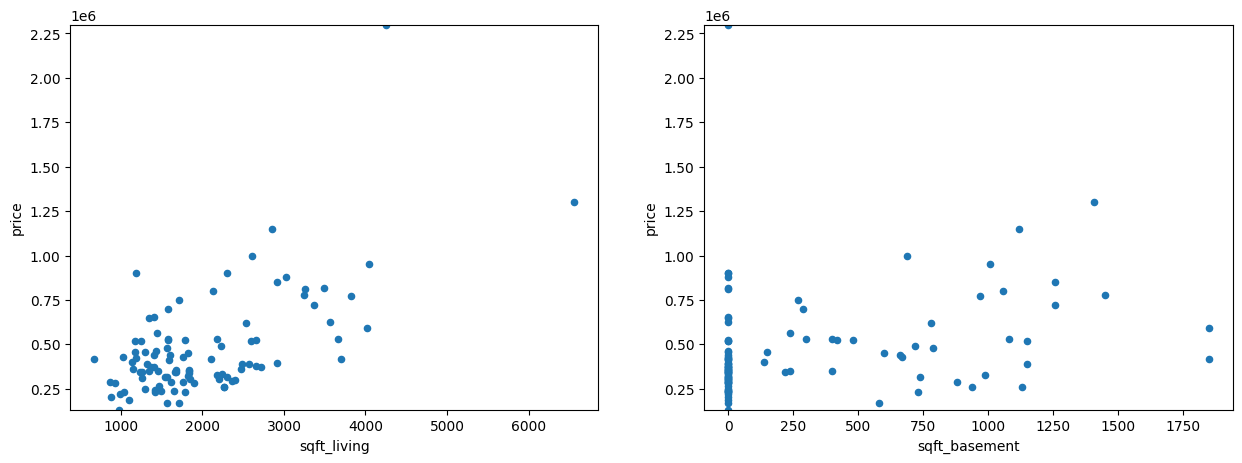

In [7]:
# Let's check the price trend as a function of the sqrt_living and sqrt_basement (separately)

def plot_single_feature_vs_y(feature, train_data, ax=None, y='price'):
    reduced_data = pd.concat([train_data[y], train_data[feature]], axis=1)
    reduced_data.plot.scatter(x=feature, y=y, ylim=(train_data[y].min(), train_data[y].max()), ax=ax)

fig, axes = plt.subplots(1,2, figsize=(15,5))
plot_single_feature_vs_y('sqft_living', train_data, ax=axes[0])
plot_single_feature_vs_y('sqft_basement', train_data, ax=axes[1])

# Note 'sqft_basement' might not be easily used to predict Y (many values are zero while 'price' has different values)

In [8]:
# Let's explore data and features distributions using box plots
def box_plot_single_feature_vs_y(feature, train_data):
    plt.figure(figsize=(15,10))
    reduced_data = pd.concat([train_data['price'], train_data[feature]], axis=1)
    sns.boxplot(x=feature, y="price", data=reduced_data)

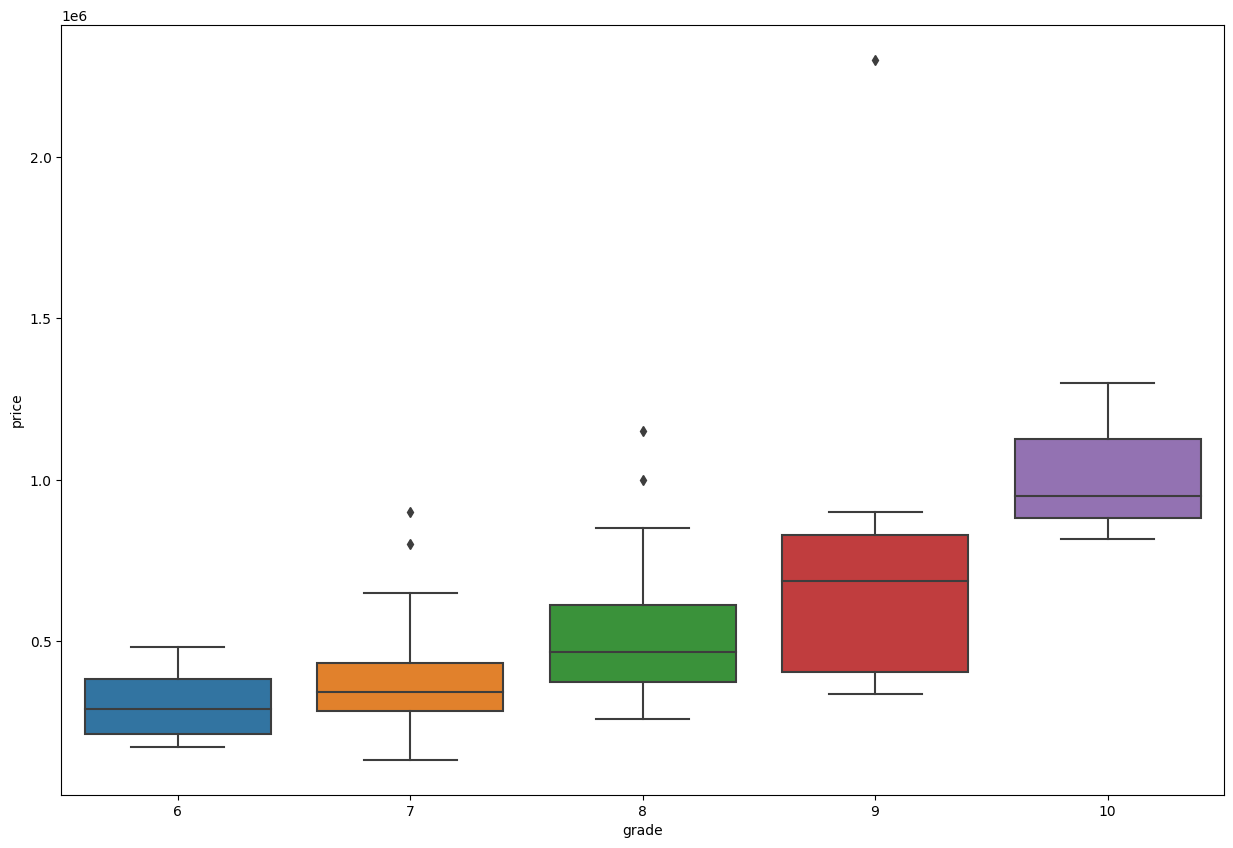

In [9]:
# Prices over 'grade'
box_plot_single_feature_vs_y('grade', train_data)

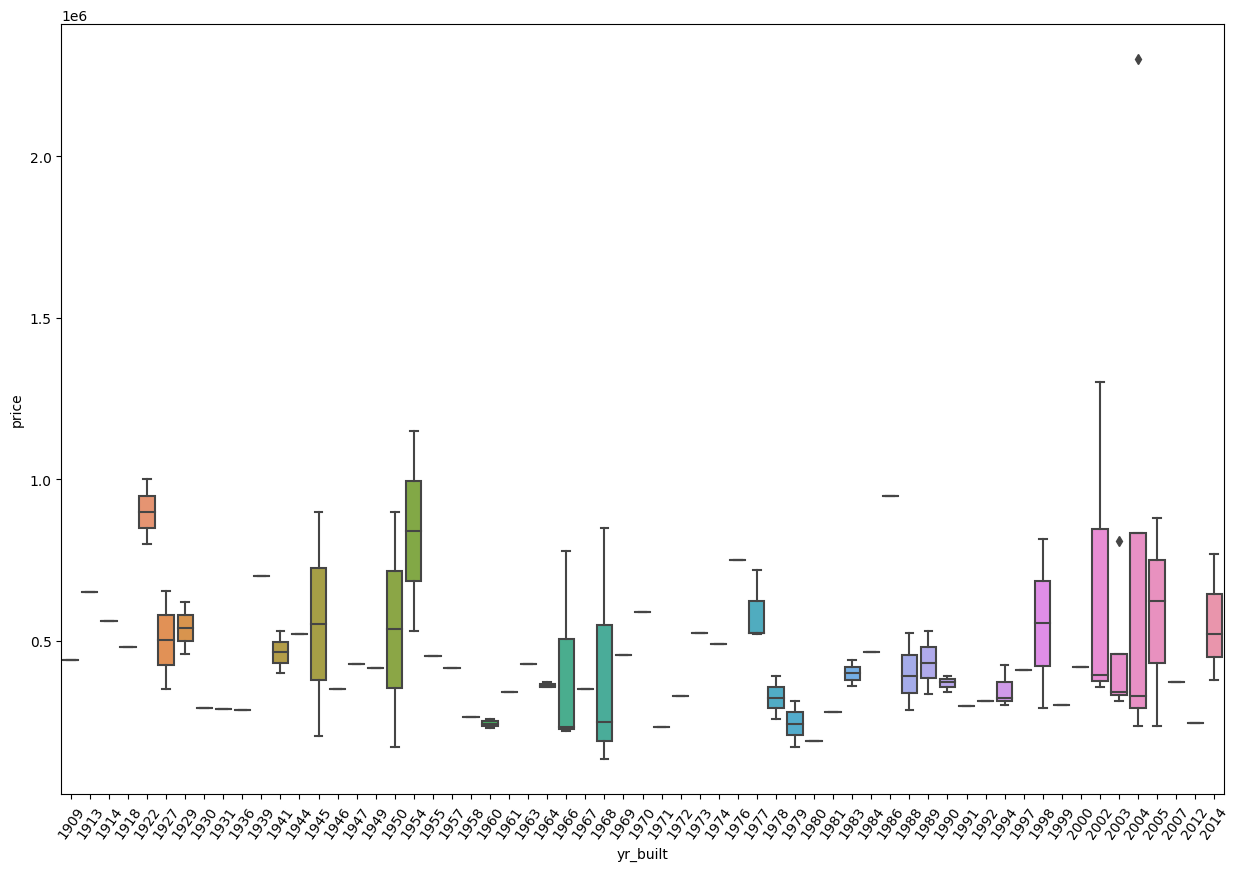

In [10]:
# Prices over 'yr_built'
box_plot_single_feature_vs_y('yr_built', train_data)
plt.xticks(rotation=55)
plt.show()

**Note**: 'grade' seems to correlate well with the regression variable 'price' (the higher the 'grade' the higher the
 'price'). On the other hand it is not clear whether there is correlation between 'yr_built' and 'price'.
 You can try to inspect other features and how they correlate with 'price'.

Additional Box Plots of parameters that correllate well with the price other than **grade**

In [11]:
# box_plot_single_feature_vs_y('bathrooms', train_data)
# box_plot_single_feature_vs_y('view', train_data)
# box_plot_single_feature_vs_y('sqft_living15', train_data)
# plt.xticks(rotation=70)
# box_plot_single_feature_vs_y('sqft_above', train_data)
# plt.xticks(rotation=70)
# box_plot_single_feature_vs_y('sqft_living', train_data)
# plt.xticks(rotation=70)
# plt.show

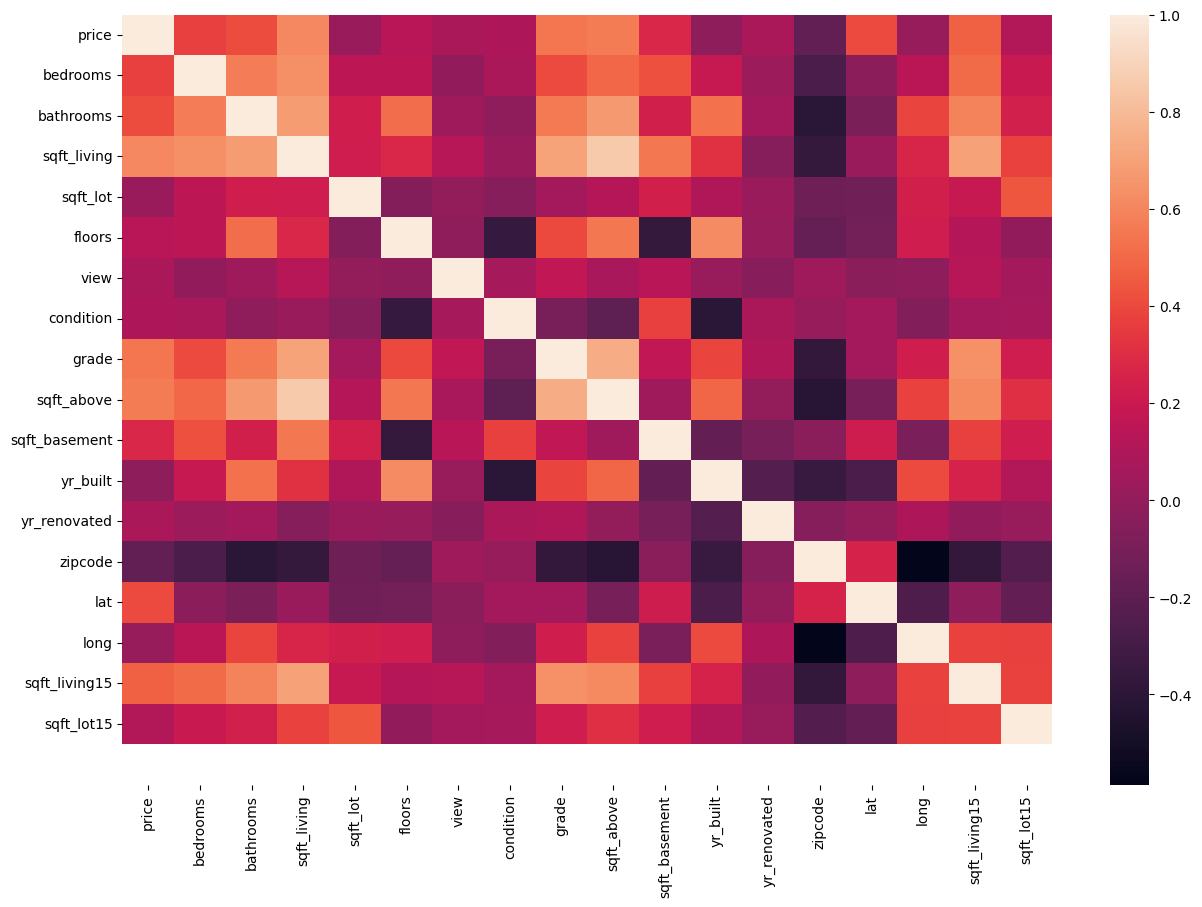

In [12]:
# Let's' try to make the process we followed up to now a little bit more systematic: we will use a pandas 
# built-in function to plot the correlation matrix between all the features and the regression variables.

def plot_correlation_matrix(df_train):
    plt.subplots(figsize=(15, 10))
    corr_matrix = df_train.corr()
    ax = sns.heatmap(corr_matrix, vmax=1, square=False)
    ax.set_ylim(19, 0)
    return corr_matrix

corr_matrix = plot_correlation_matrix(train_data)

(19.0, 0.0)

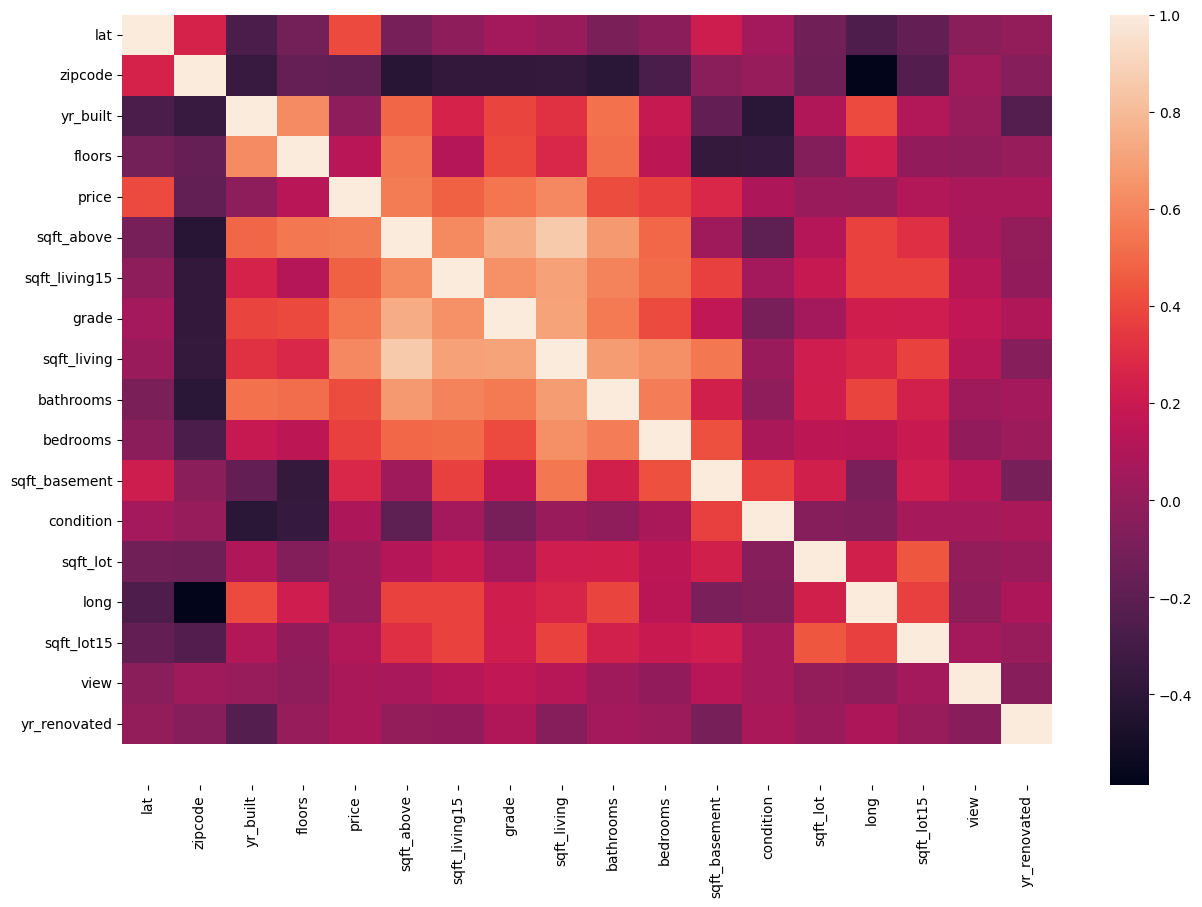

In [13]:
# Previous correlation matrix is not ordered, we need to sort its entries such that we can cluster the most 
# correlated variables. In this way it will be easier to read the correlation matrix.

import scipy
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False) -> pd.DataFrame:
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    :param corr_array: pandas.DataFrame or numpy.ndarray a NxN correlation matrix 
        
    :returns: A NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

plt.subplots(figsize=(15, 10))
corr_matrix = cluster_corr(corr_matrix, inplace=False)
ax = sns.heatmap(corr_matrix, vmax=1, square=False)
ax.set_ylim(19, 0)

Note the 'clusters' along the diagonal. Actually, some of these correlations are so strong that it might indicate a situation of multicollinearity. 
This means these variables are in some sense redundant (they give almost the same information) and might not be useful to build our final linear model.

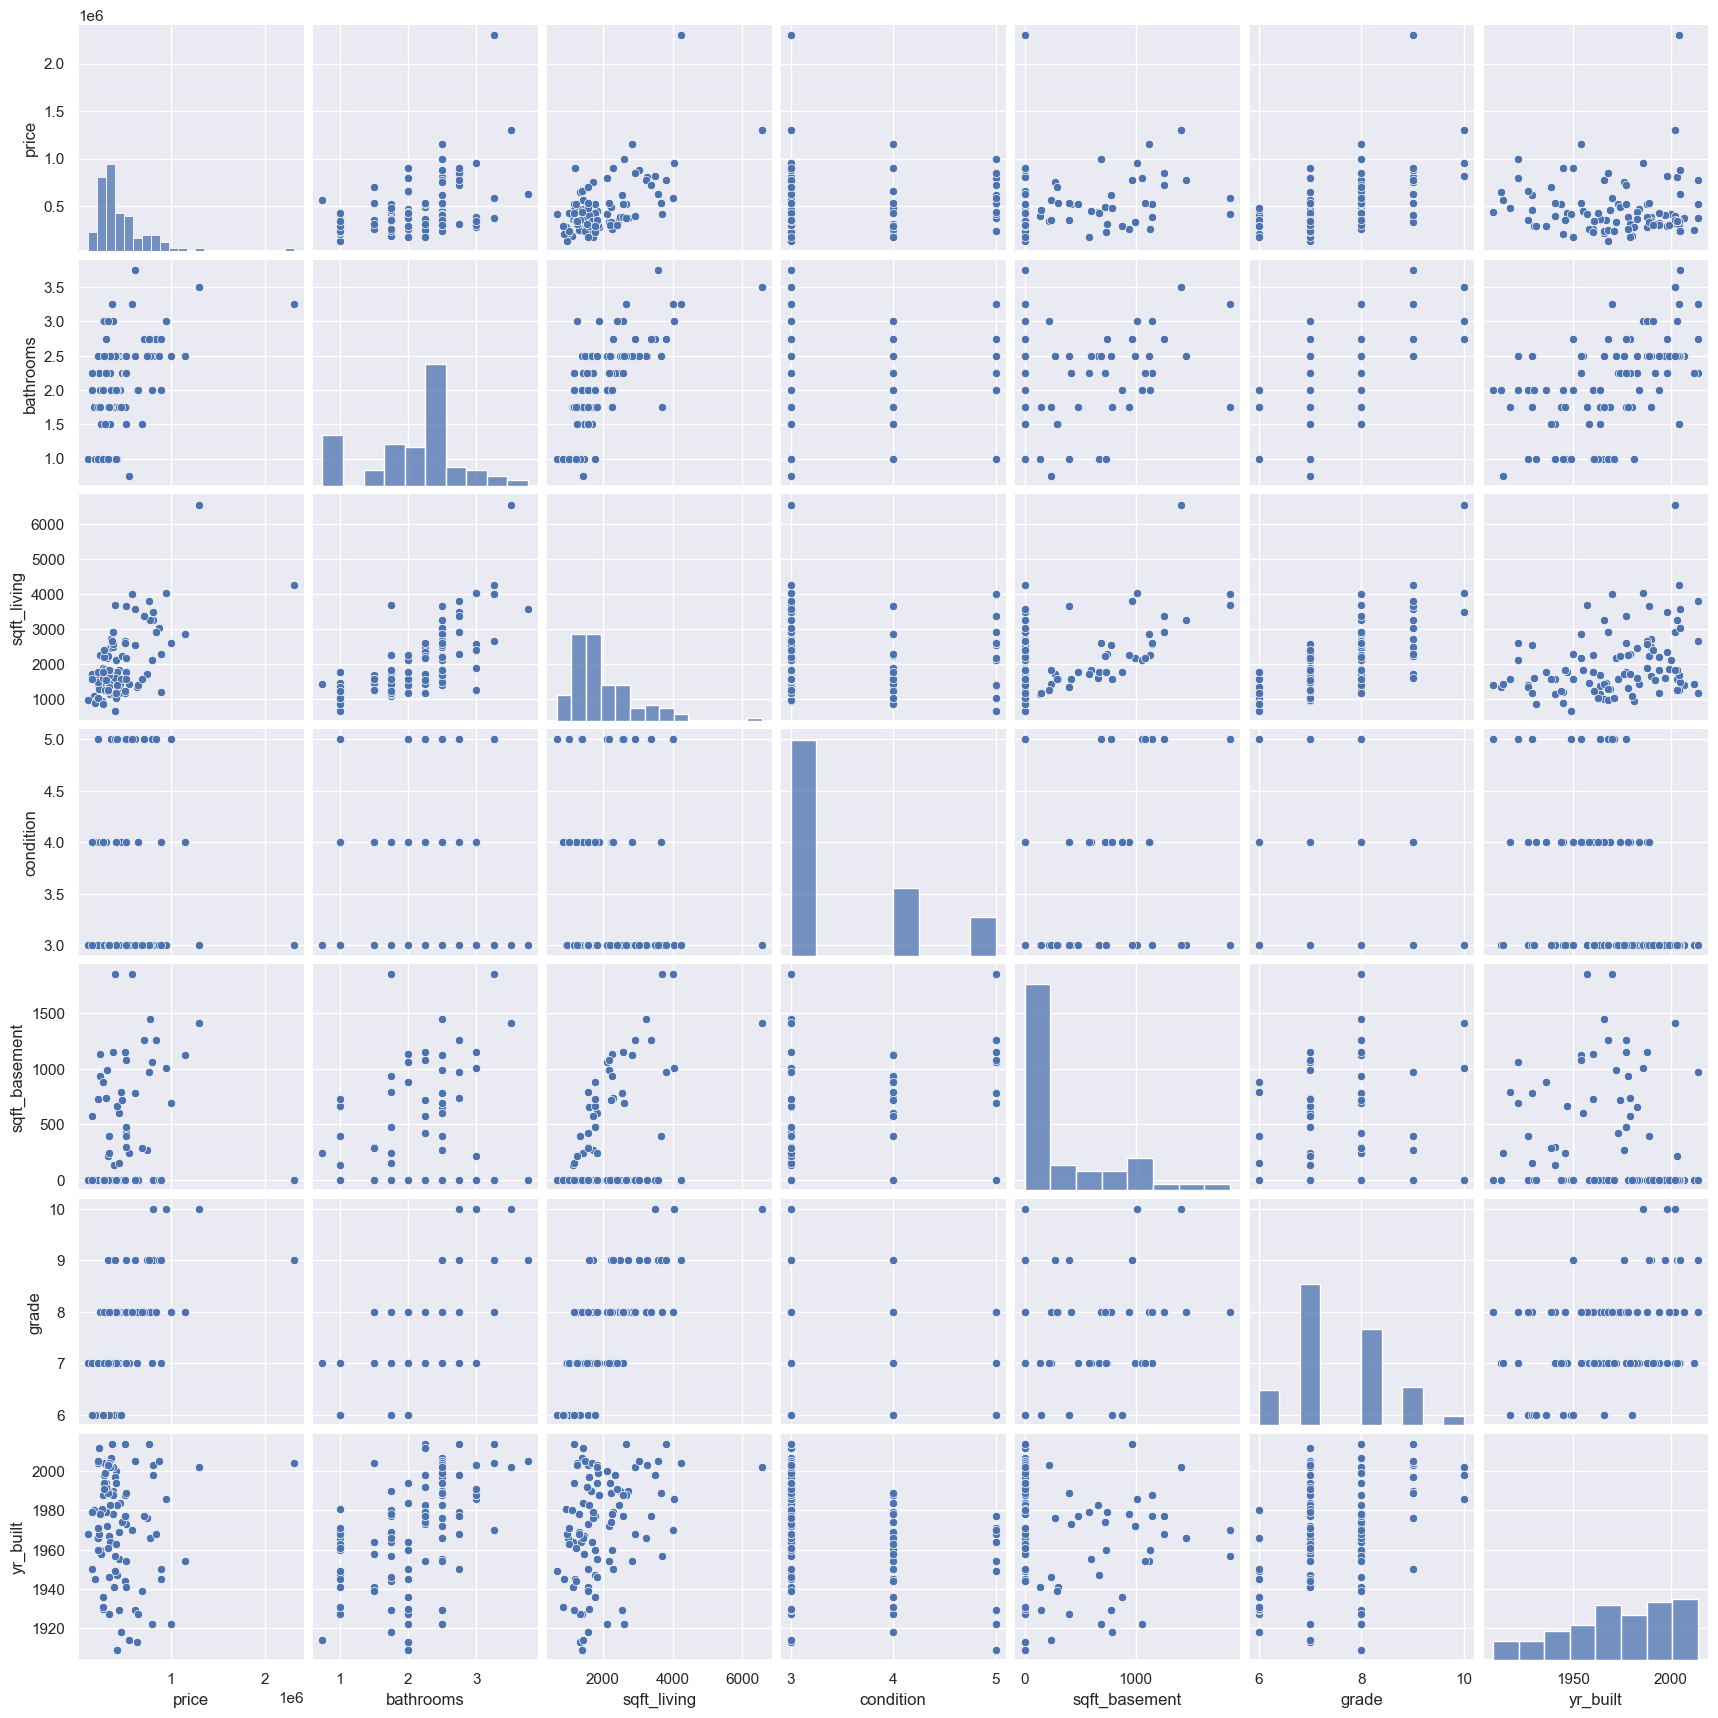

In [14]:
# Let's have a look at some scatter plots (in the main diagonal there is a histogram with the actual data)
sns.set()
cols = ['price', 'bathrooms', 'sqft_living', 'condition', 'sqft_basement', 'grade', 'yr_built']
sns.pairplot(train_data[cols], size = 2.5)
plt.show()
# As we see in the correlation matrix 'condition' and 'yr_build' are very poorly correlated

**Note**: We can remove features that we believe are much correlated with others (leaving at least one of them), since they can be thought as redundant. Don't forget we should keep into account how much each feature is correlated with the regression variable too.

In [15]:
# Let's now standardize the data as we did in the past homeworks
features_names = train_data.columns[1:]
x_train, y_train = train_data[features_names].values.astype('float'), train_data['price'].values.astype('float')
x_test, y_test = test_data[features_names].values.astype('float'), test_data['price'].values.astype('float')

from sklearn import preprocessing
scaler_x = preprocessing.StandardScaler().fit(x_train)
x_train = scaler_x.transform(x_train)

scaler_y = preprocessing.StandardScaler().fit(y_train.reshape(-1,1))
y_train = scaler_y.transform(y_train.reshape(-1,1)).reshape(-1,)

x_test = scaler_x.transform(x_test)
y_test = scaler_y.transform(y_test.reshape(-1,1)).reshape(-1,)

**Additional block:**

In [16]:
print(x_train.shape)
print(y_train.shape)
d = x_train.shape[1]
print(d)

(100, 17)
(100,)
17


**Additional block:**

In [17]:
print(f"Mean of the training input data:   {x_train.mean(axis=0)}")
print(f"Std of the training input data:    {x_train.std(axis=0)}")
print(f"Mean of the test input data:   {x_train.mean(axis=0)}")
print(f"Std of the test input data:    {x_train.std(axis=0)}")

Mean of the training input data:   [-8.10462808e-17  1.69864123e-16 -6.55031585e-17  2.22044605e-18
 -2.22044605e-18  1.38777878e-17 -2.52020627e-16  4.35207426e-16
 -1.33226763e-17  2.02615702e-17 -4.05231404e-15  8.88178420e-18
 -4.37749836e-14 -3.04467562e-14 -1.76902937e-14  5.32907052e-17
  8.43769499e-17]
Std of the training input data:    [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean of the test input data:   [-8.10462808e-17  1.69864123e-16 -6.55031585e-17  2.22044605e-18
 -2.22044605e-18  1.38777878e-17 -2.52020627e-16  4.35207426e-16
 -1.33226763e-17  2.02615702e-17 -4.05231404e-15  8.88178420e-18
 -4.37749836e-14 -3.04467562e-14 -1.76902937e-14  5.32907052e-17
  8.43769499e-17]
Std of the test input data:    [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


**Additional function to check bias of a set**

In [18]:
def add_bias_column(matrix):
    # Ensure matrix is 2-dimensional
    matrix = matrix.reshape(-1, 1) if matrix.ndim == 1 else matrix
    # Add bias column only if it's not already present
    if not np.all(matrix[:, 0] == 1):
        matrix = np.hstack((np.ones((matrix.shape[0], 1)), matrix))
    return matrix

In [19]:
# TODO 1
# Write a function to compute the Least-Squares estimate using LinearRegression() from Scikit-learn given x_train and 
# y_train. The function must return the COD both for training and test dataset AND must return a vector containing 
# all the model parameters (both bias b and coefficients w)
from sklearn import linear_model 
def solve_LS_problem(x_train : np.ndarray, y_train : np.array, x_test : np.ndarray, y_test : np.array) -> tuple:
    '''
    Funtion used to compute the LS estimate given train data. This function uses Scikit-learn to get both the LS 
    solution and other required quantities.
    :param x_train: input data used to get the linear model predictions
    :param y_train: output data to be predicted
    :param x_test: test features used to assess model performance
    :param y_test: test output to be predicted to assess model performance
    
    :returns: (COD_train, COD_test, w)
        WHERE
        COD_train : Coefficient of determination for the training dataset (float)
        COD_test : Coefficient of determination for the test dataset (float)
        w : parameters of the linear model (the bias is contained, return it as the first element of w) 
            of shape (#parameters + 1,)
    '''
    
    # YOUR CODE HERE
    # # to make sure that the size is the original one, before stacking with ones 
    # assert x_train.shape[1] == d
    # assert x_test.shape[1] == d 

    # stack data with ones, so as to add bias term
    # x_train = add_bias_column(x_train)
    # x_test  = add_bias_column(x_test)

    # train the model
    reg = linear_model.LinearRegression().fit(x_train, y_train)
    
    # calculate CODs
    COD_train = reg.score(x_train, y_train)
    COD_test = reg.score(x_test, y_test)
    
    # concatenate intercept with coefficients 
    w = np.insert(reg.coef_, 0, reg.intercept_)
    
    return (COD_train, COD_test, w)

In [20]:
COD_train_LS_full, COD_test_LS_full, w_LS_full = solve_LS_problem(x_train, y_train, x_test, y_test)
print(f"Coefficient of determination on training data: {COD_train_LS_full:.4f}")
print(f"Coefficient of determination on test data:     {COD_test_LS_full:.4f}")
print(f"w_LS_full:{w_LS_full}")

assert w_LS_full.shape == (18,)
assert type(COD_train_LS_full) == np.float64 and COD_train_LS_full <= 1.0
assert type(COD_test_LS_full) == np.float64 and COD_test_LS_full <= 1.0


Coefficient of determination on training data: 0.6382
Coefficient of determination on test data:     0.6066
w_LS_full:[ 2.79448724e-15 -9.24320687e-03  1.43028908e-01  2.48850031e-01
  1.29969029e-02 -1.06828718e-01  2.86167247e-02  7.71395460e-02
  8.10749147e-02  3.97422100e-01 -1.61411775e-01 -2.01949558e-01
  2.26630673e-02 -1.20800546e-01  3.89610552e-01 -1.70846237e-01
  7.02673599e-02 -3.12958293e-02]


### TODO 2: explain the results
Explain the effect of the pre-processing on the first value of w_LS_full.

Similar to how we had seen in **HW_1_LR** when preprocessing is done what we're doing in practice is scaling our data so that the **mean** and **std** (the variance does not affect this case here, its only the mean but its worth mentioning) are 0 and 1 respectively. The **first value of w_LS_full** represents the **intercept**, so in the following formula for a linear regression model: $$h(x) = w^Tx + b$$ It is the $b$ value. $b$ represents represents $\mathbb{E}[h(x)]$ when all x is equal to 0 (in our case its almost 0, $2.79^{-15}$). Now in the earlier step we have centered our data, so the point $(x=0, y=0)$ is exactly the center of the data and the regression hyperplane passes through the origin ensuring the intercept is also 0, and the regression equation is nothing but the following in the end $$h(x) = w^Tx$$

In [21]:
# TODO 3
# Based on the observations we made earlier looking at the dataset (correlation and scatter plots) which variables 
# would you choose to predict the price? Choose the 4 most important features based on your intuition.
# Here we plot features and their indeces for your ease of use
print({index: feature for index, feature in enumerate(features_names)})

{0: 'bedrooms', 1: 'bathrooms', 2: 'sqft_living', 3: 'sqft_lot', 4: 'floors', 5: 'view', 6: 'condition', 7: 'grade', 8: 'sqft_above', 9: 'sqft_basement', 10: 'yr_built', 11: 'yr_renovated', 12: 'zipcode', 13: 'lat', 14: 'long', 15: 'sqft_living15', 16: 'sqft_lot15'}


In [22]:
hand_selected_features_indeces = None # Replace with a list of 4 indeces, select them from the train and test sets and then solve the reduced (in the number of 
                                      # features) LS problem using the function we built before
COD_train_LS_reduced, COD_test_LS_reduced, w_LS_reduced = None, None, None  # Replace with proper values

# YOUR CODE HERE

# # the features that are choosen are grade, sqft_living15, sqft_above and sqft_living
# hand_selected_features_indeces = [7, 15, 8, 2]

# # the features that are choosen are grade, sqft_living, view, bathrooms
# hand_selected_features_indeces = [7, 2, 5, 1]

# the features that are choosen are grade, sqft_living15, view, bathrooms
# hand_selected_features_indeces = [7, 15, 5, 1]

# # the features that are choosen are grade, sqft_above, view, bathrooms
# hand_selected_features_indeces = [7, 8, 5, 1]

# # the features that are choosen are grade, sqft_living, bedrooms, bathrooms 
# hand_selected_features_indeces = [7, 2, 0, 1]

# # the features that are choosen are bedrooms, bathrooms, sqft living, sqft lot
# hand_selected_features_indeces = [0, 1, 2, 3]

# # the features that are choosen are grade, sqft_living, condition, bathrooms 
# hand_selected_features_indeces = [7, 2, 6, 1]

# # the features that are choosen are grade, sqft_living, condition, bathrooms 
# hand_selected_features_indeces = [7, 2, 6, 1]

# # the features that are choosen are 
hand_selected_features_indeces = [7, 2, 13, 1]
# the features are chosen are bathrooms, sqft_above, lat, grade
# hand_selected_features_indeces = [1, 8, 13, 7]

# # from BSS
# hand_selected_features_indeces = [2, 7, 13, 10]

# solve the reduced LS problem
COD_train_LS_reduced, COD_test_LS_reduced, w_LS_reduced = solve_LS_problem(x_train[:, hand_selected_features_indeces], y_train, 
                                                                  x_test[: , hand_selected_features_indeces], y_test)

print(f"Coefficient of determination on training data: {COD_train_LS_reduced:.4f}")
print(f"Coefficient of determination on test data:     {COD_test_LS_reduced:.4f}")

Coefficient of determination on training data: 0.5406
Coefficient of determination on test data:     0.5855


In [23]:
# Additional
print(w_LS_reduced)

[1.16059554e-14 1.98323484e-01 4.38305735e-01 3.80666594e-01
 3.13896198e-02]


In [24]:
assert w_LS_reduced.shape == (5,)


### TODO 4: 
What is your reasoning behind the choice of the 4 features you selected in the todo 3?  

The reason behind this choice was analyzing the following three: 

1. **Box Plots:** After plotting additional box plots to visualize which features correlate best with 'price' other than grade which we're already aware about. From this observation I came to the conclusion that the following features correllate decently well with 'price':
    - grade
    - sqft_living 
    - sqft_living15
    - bathrooms
    - sqft_above
    - bedrooms
    - lat
2. **Ordered Correlation Matrix:** This provides more intution into the features that were selected at the first stage using the box plots, in the sense to show multicollinearity between themselves or not. For example, from this we could understand that **'sqft_living', 'sqft_above' and 'sqft_living15' are highly correlated** so even though they correllate with price well, choosing all these features can introduce multicollinearity, and in the end we would like to improve the diversity of the model. It is also the similar situation with **'bathrooms' and 'bedrooms'** both are highly correllated. So we choose one of them which has the strongest correlation with 'price' and exclude the rest, as the rest are redundant. 
3. **Scatter Plots correllation with features:** This visualization technique further enhances our ability to spot multicorrelation between features, as each datapoint is marked here and is not provided as only a heatmap on the correaltion.  

The visualizations used to make this decesion can be viewed below. 


**Addition scatter plot to spot multicorrelation**

In [25]:
### UNCOMMENT BEFORE SUBMISSION 
# cols = [ 'price', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_above', 'bedrooms', 'bathrooms', 'grade']
# sns.pairplot(train_data[cols], size = 2.5)
# plt.show()

**Additional box plots to show correlation of certain features with 'price'**

In [26]:
### UNCOMMENT BEFORE SUBMISSION 
# box_plot_single_feature_vs_y('bathrooms', train_data)
# box_plot_single_feature_vs_y('lat', train_data)
# plt.xticks(rotation=80)
# box_plot_single_feature_vs_y('bedrooms', train_data)
# box_plot_single_feature_vs_y('condition', train_data)
# plt.xticks(rotation=80)
# box_plot_single_feature_vs_y('sqft_living15', train_data)
# plt.xticks(rotation=70)
# box_plot_single_feature_vs_y('sqft_above', train_data)
# plt.xticks(rotation=70)
# box_plot_single_feature_vs_y('sqft_living', train_data)
# plt.xticks(rotation=70)
# plt.show

## Best-Subset Selection

What if we try a brute force approach? Are the features you selected the same as the ones you would get by looking at all the possible combinations?

In the next cell we are going to split x_train into a ("new") training dataset (x_train_BSS) and validation dataset (x_val_BSS) to perform best-subset selection (remember the validation dataset is used to find the best generalizing model among the ones, with different number of features, you trained using x_train_BSS). 

We are going to choose subsets of features going from $1$ to $n_{sub}=4$. In theory we should try all the possible combinations of size $1,2, \dots, 18$ but the number of models to train and validate would be huge! For the sake of simplicity we will choose all the possible subsets of dimension $1$ to $4$.

Steps:
1. Compute the LS estimate using all the possible subsets of $k$ features
2. Compute the prediction error on the validation dataset
3. Choose the subset of $k^*$ features giving the lowest validation error

In [27]:
# TODO 5 
# Let's get the validation dataset from the training dataset (don't forget they must be disjoint, of course we could 
# have splitted them before, during the pre-processing step)
import itertools

m_train_BSS, m_val_BSS = m_t // 2, m_t - m_t // 2

x_train_BSS, y_train_BSS = x_train[:m_train_BSS], y_train[:m_train_BSS]
x_val_BSS, y_val_BSS = x_train[m_train_BSS:], y_train[m_train_BSS:]


nsub = 4
features_idx_dict, validation_err_dict = {}, {}
for k in range(1,nsub + 1):
    features_idx = list(itertools.combinations(range(x_train_BSS.shape[1]), k))
    validation_error = np.zeros(len(features_idx),)
    for j in range(len(features_idx)):
        # You should use the function you built in previous TODO
        # YOUR CODE HERE
        COD_train_BSS, COD_val_BSS, w_LS_BSS = solve_LS_problem(x_train_BSS[:, features_idx[j]], y_train_BSS, 
                                                                  x_val_BSS[:, features_idx[j]], y_val_BSS)
        validation_error[j] = 1 - COD_val_BSS
    print(f'Number of models trained for {k} chosen features: {len(features_idx)}')
    
    features_idx_dict.update({k: features_idx})
    validation_err_dict.update({k: validation_error})
    
validation_err_min_per_size = {k+1: np.min(val_errs) for k, val_errs in enumerate(validation_err_dict.values())}
validation_err_argmin_per_size = {k+1: np.argmin(val_errs) for k, val_errs in enumerate(validation_err_dict.values())}

Number of models trained for 1 chosen features: 17
Number of models trained for 2 chosen features: 136
Number of models trained for 3 chosen features: 680
Number of models trained for 4 chosen features: 2380


In [28]:
number_subsets_per_group = [int(scipy.special.comb(17, k)) for k in range(1, nsub + 1)]
for k, n_SubSet in zip(range(1, nsub + 1), number_subsets_per_group): 
    assert len(validation_err_dict[k]) == n_SubSet
    

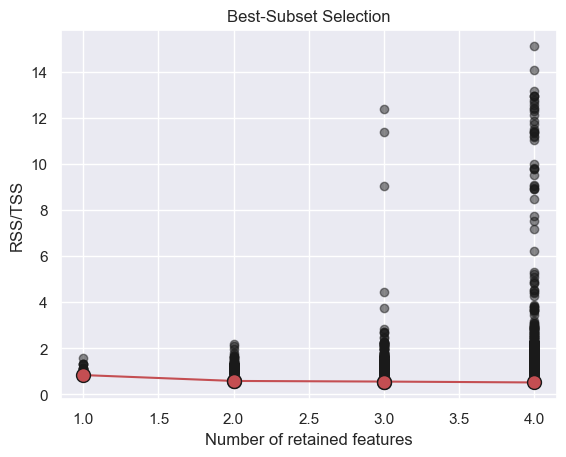

In [29]:
# Plot the validation score for each model
plt.figure(2)
for k in range(1,nsub+1):
    plt.scatter(k*np.ones(validation_err_dict[k].shape), validation_err_dict[k], color='k', alpha=0.5)
    if k > 1:
        plt.plot([k-1, k], [validation_err_min_per_size[k-1], validation_err_min_per_size[k]], color='r',marker='o', 
            markeredgecolor='k', markerfacecolor = 'r', markersize = 10)
plt.xlabel('Number of retained features')
plt.ylabel('RSS/TSS')
plt.title('Best-Subset Selection')
plt.show()

In [30]:
# TODO 6
# Pick the number of features for the best subset according to figure above, select the best subset using the results 
# above and learn the model on the entire training data (x_train); eventually compute COD on training (x_train) and 
# on test data (x_test).

# Now pick the number of features according to best subset
opt_num_features = 4
opt_features_idx = features_idx_dict[opt_num_features][validation_err_argmin_per_size[opt_num_features]]

# You should use the function you built in previous TODOs
COD_train_BSS, COD_test_BSS, w_hat_BSS = None, None, None # Replace with the proper quantities
# YOUR CODE HERE
COD_train_BSS, COD_test_BSS, w_hat_BSS = solve_LS_problem(x_train[:, opt_features_idx], y_train, 
                                                                  x_test[:, opt_features_idx], y_test)
# Let's print the indices of the features from best subset
print(f'Best features indexes: {opt_features_idx}')
print(f'Best features names: {str({features_names[i] for i in opt_features_idx})}')

# Let's print model performance on train and test datasets (measured using COD)
print(f"Coefficient of determination on training data: {COD_train_BSS:.4f}")
print(f"Coefficient of determination on test data:     {COD_test_BSS:.4f}")

Best features indexes: (2, 7, 10, 13)
Best features names: {'yr_built', 'lat', 'grade', 'sqft_living'}
Coefficient of determination on training data: 0.5636
Coefficient of determination on test data:     0.6337


In [31]:
assert len(opt_features_idx) == opt_num_features

### Ridge regression 

Recall that for linear models with scalar output we have $h(x) = <w,x>$ and that the Empirical error $L_S(h)$ can be written
in terms of the vector of parameters $w$, in the form:
$$
L_S(w) = \frac{1}{m_t} \|Y - X w\|^2
$$
where $Y$ and $X$ are the matrices whose $i-$th rows are, respectively, the output data $y_i$ and the input vectors $x_i^\top$.

In the case of Ridge regression we add a regularization term to the RSS term so that our Empirical error becomes: 
$$
L_S(w) = \frac{1}{m_t} \|Y - X w\|^2 + \lambda \|w\|^2 \propto \|Y - X w\|^2 + \underbrace{\lambda * m_t}_{:=\alpha} \|w\|^2
$$
The Ridge Least Squares solution is given by the expression:
$$
\hat w_{Ridge} = {\rm arg\;min}_w L_S(w) = (X^\top X + \alpha I)^{-1} X^\top Y
$$

__Note__: what has changed w.r.t. the LS solution? Do we need to worry about invertibility of the matrix we need to invert? 
- Prove that adding a positive multiple of identity to a semi definite positive matrix you get a positive definite matrix.
- Prove that a positive definite matrix is *always* invertible. 


In [32]:
# TODO 7 
# Write a function which computes the optimal parameters w_hat, solution to the LS regularized problem described 
# earlier.
# We assume w_hat contains the bias term b (as described in class), so you will need to create the proper input data 
# adding a fictitious feature containing only ones (it is assumed you add the ones vector before all your features
# so that b_hat is in the first position of w_hat). 
# Then write a function "solve_ridge_LS_problem", similar in spirit to "solve_LS_problem" (see function description 
# for details on the input and return values).
def compute_LS_optimal_ridge_ERM_coefficients(x_train : np.ndarray, y_train : np.ndarray, alpha : float) -> np.ndarray:
    '''
    This function estimates the optimal Ridge LS coefficients given the input and output training data x, y. 
    This function assumes the bias term b is condensed with the other coefficients, therefore a column of ones is 
    stacked (place it in front of the feature vector) to the input features and the size of the returned optimal 
    coefficient is: number of features + 1
    
    :param x_train: input features 
    :param y_train: output to be predicted
    :param alpha: regularization parameter
    
    :returns: a column vector containing w_hat, solution to the ridge ERM LS problem    
    '''
    # YOUR CODE HERE

    # add coloumn of ones in the beginning of the feature vector
    x_train = add_bias_column(x_train)

    # X^TX and X^TY
    A = np.matmul(x_train.T, x_train)
    B = np.matmul(x_train.T, y_train)

    # calculation of the alpha matrix
    alpha_matrix = np.zeros((x_train.shape[1], x_train.shape[1]))
    np.fill_diagonal(alpha_matrix, alpha)

    # w_hat calculation
    w_hat = np.matmul( np.linalg.inv(A + alpha_matrix), B)

    return w_hat


def solve_ridge_LS_problem(x_train : np.ndarray, y_train : np.array, x_test : np.ndarray, y_test : np.array, 
                           alpha : float) -> tuple:
    '''
    Funtion used to compute the ridge LS estimate given train data and alpha hyper-parameter. 
    This function uses Scikit-learn to get both the ridge LS solution and other required quantities.
    Note you could have implemented this function using your own "compute_LS_optimal_ridge_ERM_coefficients"
    but it is faster and easier for you to compute training loss and test one using Scikit-learn implementation.
    :param x_train: input data used to get the linear model predictions
    :param y_train: output data to be predicted
    :param x_test: test features used to assess model performance
    :param y_test: test output to be predicted to assess model performance
    :param alpha: regularization hyper-parameter
    
    :returns: (COD_train, COD_test, w)
        WHERE
        COD_train : Coefficient of determination for the training dataset
        COD_test : Coefficient of determination for the test dataset
        w : parameters of the linear model (the bias is contained, return it as the first element of w)
    '''
    # YOUR CODE HERE
    ridge_model = linear_model.Ridge(alpha=alpha)
    ridge_model.fit(x_train, y_train)
    
    # concatenate intercept with coefficients 
    w = np.insert(ridge_model.coef_, 0, ridge_model.intercept_)

    # calculation of CODs
    COD_train = ridge_model.score(x_train, y_train)
    COD_test = ridge_model.score(x_test, y_test)
    
    return (COD_train, COD_test, w)


alpha = 0.1
w_hat_ridge_hand = compute_LS_optimal_ridge_ERM_coefficients(x_train, y_train, alpha = alpha)
print(f"w_hat \n {w_hat_ridge_hand}")

w_hat 
 [ 2.84065159e-15 -8.97352302e-03  1.42491319e-01  2.48435628e-01
  1.28524773e-02 -1.06029174e-01  2.84903890e-02  7.69721304e-02
  8.16610841e-02  3.96365552e-01 -1.60501432e-01 -2.01766066e-01
  2.26932681e-02 -1.20444038e-01  3.89048299e-01 -1.70290588e-01
  7.04200415e-02 -3.12533256e-02]


In [33]:
# Compare your ridge regression solution with sklearn one.
# The following lines are also a hint on how to create the function 'solve_ridge_LS_problem'
ridge = linear_model.Ridge(alpha=alpha)
ridge.fit(x_train, y_train)
ridge.coef_.shape, ridge.intercept_.shape
w_hat_ridge_sklearn = np.concatenate((ridge.intercept_.reshape(-1,), ridge.coef_))

print(f"w_hat_sklearn \n {w_hat_ridge_sklearn}")
COD_train_ridge, COD_test_ridge, w_hat_ridge = solve_ridge_LS_problem(x_train, y_train, x_test, y_test, alpha)

# Let's print model performance on train and test datasets (measured using COD)
print(f"Coefficient of determination on training data: {COD_train_ridge:.4f}")
print(f"Coefficient of determination on test data:     {COD_test_ridge:.4f}")

assert np.isclose(w_hat_ridge_hand, w_hat_ridge_sklearn, atol=1e-8).all()
assert np.isclose(w_hat_ridge_hand, w_hat_ridge, atol=1e-8).all()

w_hat_sklearn 
 [ 2.80329577e-15 -8.97352302e-03  1.42491319e-01  2.48435628e-01
  1.28524773e-02 -1.06029174e-01  2.84903890e-02  7.69721304e-02
  8.16610841e-02  3.96365552e-01 -1.60501432e-01 -2.01766066e-01
  2.26932681e-02 -1.20444038e-01  3.89048299e-01 -1.70290588e-01
  7.04200415e-02 -3.12533256e-02]
Coefficient of determination on training data: 0.6382
Coefficient of determination on test data:     0.6069


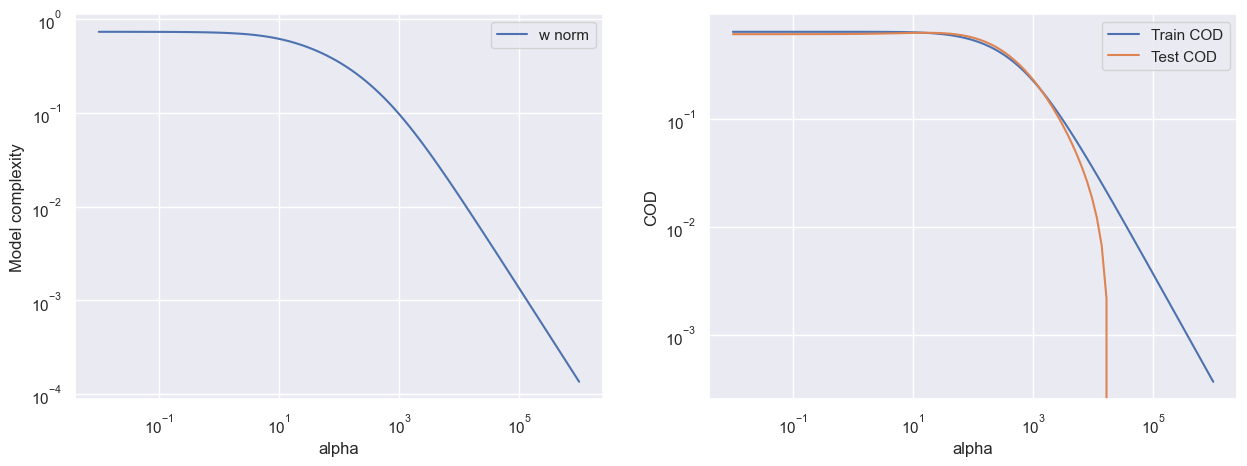

In [34]:
# Let's print model train and test metric as a function of the regularization parameter alpha (which is constraining
# model complexity, the higher the norm of w the higher model complexity)

alphas = np.logspace(-2, 6, 100)
ridge_results = [solve_ridge_LS_problem(x_train, y_train, x_test, y_test, a) for a in alphas]

train_CODs = list(zip(*ridge_results))[0]
test_CODs = list(zip(*ridge_results))[1]
all_w_hat = list(zip(*ridge_results))[2]

fig, axes = plt.subplots(1,2, figsize=(15, 5))
axes[0].plot(alphas, list(map(np.linalg.norm, all_w_hat)), label='w norm')
axes[0].legend()
axes[0].set_xlabel('alpha')
axes[0].set_ylabel('Model complexity')

axes[1].plot(alphas, train_CODs, label='Train COD')
axes[1].plot(alphas, test_CODs, label='Test COD')
axes[1].legend()
axes[1].set_xlabel('alpha')
axes[1].set_ylabel('COD')

# If you would like to see these plots in linear scale in x or y or both just comment the following lines
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_yscale('log')

In [35]:
# TODO 8 
# How to choose the optimal alpha? This is an hyper-parameter, usually it is estimated through Cross-validation.
# In this TODO we will implement by hand the Cross Validation procedure to estimate hyper-parameter alpha.
# The function we are going to implement is pretty general and can be applied both to Ridge and Lasso (see next)!

from sklearn.model_selection import KFold

def CV_by_hand(num_folds, model_class, other_model_hyper_parameters, loss, hyper_param_range, x_train, y_train):
    kf = KFold(n_splits = num_folds)
    loss_kfold = np.zeros(len(hyper_param_range),)
    for i in range(len(hyper_param_range)):
        for train_index, validation_index in kf.split(x_train):
            # In order to complete the following 2 lines have a look at the documentation of 
            # sklearn.model_selection.KFold (no need to insert new lines, just replace "None" with the correct 
            # quantity)
            x_train_kfold, x_val_kfold = x_train[train_index], x_train[validation_index]
            y_train_kfold, y_val_kfold = y_train[train_index], y_train[validation_index]
            # YOUR CODE HERE
            # raise NotImplementedError() # Remove this line
            
            # Initialize the model with the hyper-parameters you are willing to test (in this case we are interested
            # on alpha alone, but we might need to change the number of iterations (or other hyper-parameters, 
            # depending on the model we are using: Ridge, Lasso, etc.) to solve the ERM problem. Therefore we need 
            # to pass such an information using the dictionary "other_model_hyper_parameters")
            model_kfold = model_class(alpha=hyper_param_range[i], **other_model_hyper_parameters)
            
            # Fit the model using training data from the k-fold
            # YOUR CODE HERE
            # raise NotImplementedError() # Remove this line
            model_kfold.fit(x_train_kfold, y_train_kfold)
            
            # Compute the loss using the validation data from the k-fold
            loss_kfold[i] += loss(y_val_kfold, x_val_kfold, model_kfold)

    loss_kfold /= m_t
    
    return loss_kfold

# TODO 9: select a good set of 100 alphas to be tested, hint np.logspace(...)

n_alphas, num_folds = 100, 5
alphas = None # Replace with a proper interval (no need to add any line)

# YOUR CODE HERE
alphas = np.logspace(0.2, 1.2, num = 100) # 100 points 0 G.G 
# alphas = np.logspace(1.40, 1.50, num = 100) # 100 points 


model_class = linear_model.Ridge
other_model_hyper_parameters = {}
loss = lambda y_val, x_val, model: np.linalg.norm(y_val - model.predict(x_val))**2

# Perform CV with your implemented function
loss_ridge_kfold = CV_by_hand(num_folds, model_class, other_model_hyper_parameters, loss, alphas, x_train, y_train)

assert loss_ridge_kfold.shape == (n_alphas,)

# Choose the regularization parameter that minimizes the validation loss
best_index, ridge_alpha_opt = None, None # Replace with the correct quatities
# YOUR CODE HERE
best_index = np.argmin(loss_ridge_kfold)
ridge_alpha_opt = alphas[best_index]
# print(loss_ridge_kfold)

In [36]:
COD_train_ridge_opt, COD_test_ridge_opt, w_hat_ridge_opt = solve_ridge_LS_problem(x_train, y_train, x_test, y_test, ridge_alpha_opt)

print(f"Best value of the regularization parameter: {ridge_alpha_opt:.4f}")
# Let's print model performance on train and test datasets (measured using COD)
print(f"Coefficient of determination on training data: {COD_train_ridge_opt:.4f}")
print(f"Coefficient of determination on test data:     {COD_test_ridge_opt:.4f}")


Best value of the regularization parameter: 15.8489
Coefficient of determination on training data: 0.6250
Coefficient of determination on test data:     0.6250


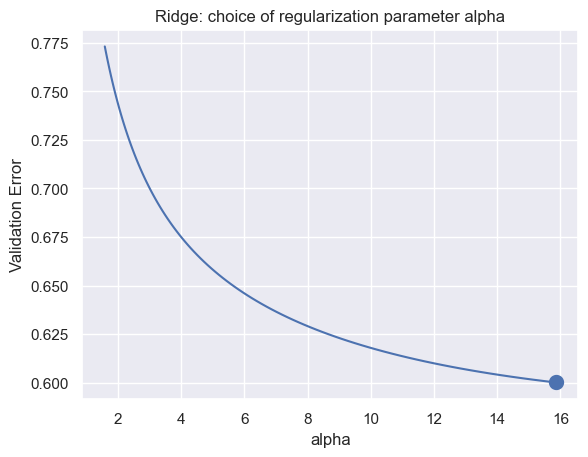

In [37]:
plt.figure()
plt.plot(alphas, loss_ridge_kfold, color='b')
plt.scatter(ridge_alpha_opt, loss_ridge_kfold[best_index], color='b', marker='o', linewidths=5)
plt.xlabel('alpha')
plt.ylabel('Validation Error')
plt.title('Ridge: choice of regularization parameter alpha')
plt.show()

COD_train_ridge_opt, COD_test_ridge_opt, w_hat_ridge_opt = solve_ridge_LS_problem(x_train, y_train, x_test, y_test, 
                                                                                  ridge_alpha_opt)

## LASSO

In the following we will apply a different regularization to our linear model: LASSO - Least Absolute Shrinkage and Selection Operator (l1 regularization)

You will code the same function as above, using functions from the Scikit-learn module, to solve the lasso LS problem for a fixed value of the regularization hyper-parameter.

After that, use the routine `lasso_path` from `sklearn.linear_regression` to compute the "lasso path" for different values of the regularization parameter $\lambda$. You should first fix a grid of possible values of lambda (the variable `lasso_lams`). For each entry of the vector `lasso_lams` you should compute the corresponding model (The $i-$th column of the vector  `lasso_coefs` should contain the coefficients of the linear model computed using `lasso_lams[i]` as regularization parameter).

Be careful that the grid should be chosen appropriately.

**Note**: the parameter $\lambda$ is called $\alpha$ in the Lasso model from sklearn.


In [38]:
# TODO 9
# As we did for ridge regression and LS, write a function to solve the Lasso LS Problem exploiting sklearn
def solve_lasso_LS_problem(x_train : np.ndarray, y_train : np.array, x_test : np.ndarray, y_test : np.array, 
                           lam : float) -> tuple:
    '''
    Funtion used to compute the LASSO LS estimate given train data and lambda hyper-parameter. 
    This function uses Scikit-learn to get both the LASSO LS solution and other required quantities.
    :param x_train: input data used to get the linear model predictions
    :param y_train: output data to be predicted
    :param x_test: test features used to assess model performance
    :param y_test: test output to be predicted to assess model performance
    :param lam: regularization hyper-parameter (what is called alphas in sklearn)
    
    :returns: (COD_train, COD_test, w)
        WHERE
        COD_train : Coefficient of determination for the training dataset
        COD_test : Coefficient of determination for the test dataset
        w : parameters of the linear model (the bias is contained, return it as the first element of w)
    '''
    
    # YOUR CODE HERE
    lasso_model = linear_model.Lasso(alpha=lam)
    lasso_model.fit(x_train, y_train)

    # concatenate intercept with coefficients 
    w = np.insert(lasso_model.coef_, 0, lasso_model.intercept_)

    # calculation of CODs
    COD_train = lasso_model.score(x_train, y_train)
    COD_test = lasso_model.score(x_test, y_test)
    
    return (COD_train, COD_test, w)


lam = 0.1
COD_train_lasso, COD_test_lasso, w_hat_lasso = solve_lasso_LS_problem(x_train, y_train, x_test, y_test, lam)

# Let's print model performance on train and test datasets (measured using COD)
print(f"Coefficient of determination on training data: {COD_train_lasso:.4f}")
print(f"Coefficient of determination on test data:     {COD_test_lasso:.4f}")

Coefficient of determination on training data: 0.5575
Coefficient of determination on test data:     0.5524


In [39]:
assert w_hat_lasso.shape == (18,)

In [40]:
# TODO 10
from sklearn.linear_model import lasso_path
# Select a grid of possible regularization parameters (be careful how this is chosen, you may have to refine 
# the choice after seeing the results)

num_lambdas = 100
lasso_lams = None # Replace with a proper interval (no need to add any line)
# YOUR CODE HERE
# as we use -np.log10
lasso_lams = np.logspace(0.5, -2.5, 100)

# Use the function lasso_path (see documentation) to compute the "lasso path", passing as input the lambda values 
# you have specified in lasso_lams
# YOUR CODE HERE
_, lasso_coefs, _ = lasso_path(x_train, y_train, alphas=lasso_lams)


In [41]:
assert lasso_coefs.shape == (17, num_lambdas)

Evaluate the sparsity in the estimated coefficients as a function of the regularization parameter $\lambda$: to this purpose, compute the number of non-zero entries in the estimated coefficient vector.

Text(0, 0.5, 'i-th parameter value')

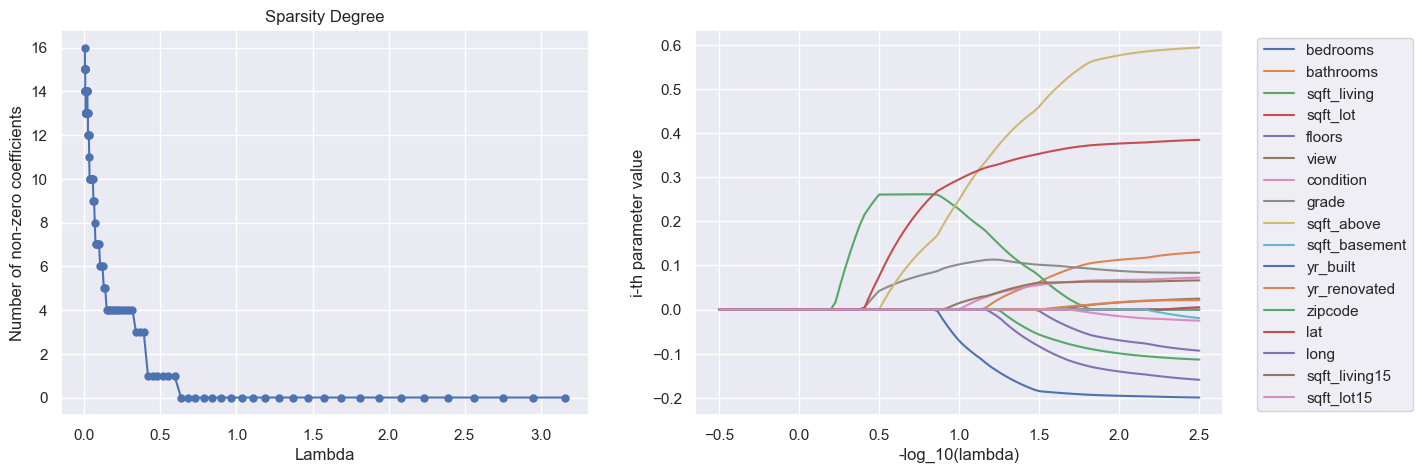

In [42]:
number_non_zero_coeffs = np.zeros(len(lasso_lams),)
# The number of non zero coeffs must be evaluated for each lambda
# YOUR CODE HERE
# list comprehension that checks each coef in each col and stores the nr of non-zero elements in the col
number_non_zero_coeffs = [np.count_nonzero(lasso_coefs[:, lambda_col]) for lambda_col in range(lasso_coefs.shape[1])]

fig, axes = plt.subplots(1,2, figsize=(15, 5))
axes[0].plot(lasso_lams, number_non_zero_coeffs, marker='o', markersize=5)
axes[0].set_xlabel('Lambda')
axes[0].set_ylabel('Number of non-zero coefficients')
axes[0].set_title('Sparsity Degree')

neg_log_alphas_lasso = -np.log10(lasso_lams) # This is used only to make a nice plot (you can directly use: lasso_lams as x value)
for i, coef_l in enumerate(lasso_coefs):
    l1 = axes[1].plot(neg_log_alphas_lasso, coef_l, label=features_names[i])
axes[1].legend(bbox_to_anchor=(1.05, 1))
axes[1].set_xlabel('-log_10(lambda)')
axes[1].set_ylabel('i-th parameter value')

In [43]:
assert len(number_non_zero_coeffs) == num_lambdas

### TODO 11: explain the results in the figures above (max 5 lines)
What does each plot mean? Did you observe what you would have expected from the theory?
Type your answer in the next cell (no code needed)

YOUR ANSWER HERE

In [44]:
# TODO 12
# Use Cross-Validation to find the optimal lam. You should use the CV function you implemented earlier.
# Once the omptimal lambda has been found, the following cell will automatically print its training and test error
num_folds, num_lambdas = 5, 100
lambdas = None # Replace with a proper interval (no need to add any line)
# YOUR CODE HERE
# lambdas = np.logspace(1, -2.5, 100) GG almost 0 
lambdas = np.logspace(-1.1, -1.5, 100)


model_class = linear_model.Lasso
other_model_hyper_parameters = {} # {'max_iter':10000} use this if you want to increase the number of iteration 
                                  # of the optimization: not required 
loss = lambda y_val, x_val, model: np.linalg.norm(y_val - model.predict(x_val))**2

# Perform CV with your implemented function
loss_lasso_kfold = CV_by_hand(num_folds, model_class, other_model_hyper_parameters, loss, lambdas, x_train, y_train)

# Do not worry if you get the warning ("Objective did not converge"). You may try to increase the number of iterations,
# but the execution time will increase.

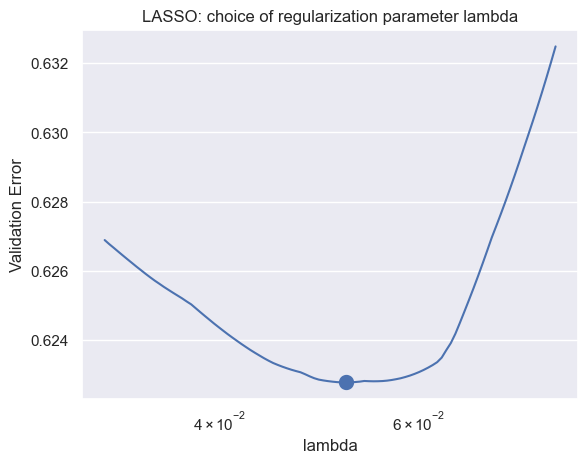

Best value of the regularization parameter: 0.0518
Coefficient of determination on training data: 0.6035
Coefficient of determination on test data:     0.5919
Total number of coefficients: 18
Number of non-zero coefficients: 11


In [45]:
assert loss_lasso_kfold.shape == (num_lambdas,)

# Choose the regularization parameter that minimizes the validation loss
best_index = np.argmin(loss_lasso_kfold)
lasso_lambda_opt = lambdas[best_index]


plt.figure()
plt.plot(lambdas, loss_lasso_kfold, color='b')
plt.scatter(lasso_lambda_opt, loss_lasso_kfold[best_index], color='b', marker='o', linewidths=5)
plt.xlabel('lambda')
plt.ylabel('Validation Error')
plt.title('LASSO: choice of regularization parameter lambda')
plt.xscale('log')
plt.show()

COD_train_lasso_opt, COD_test_lasso_opt, w_hat_lasso_opt = solve_lasso_LS_problem(x_train, y_train, x_test, y_test, 
                                                                                  lasso_lambda_opt)

print(f"Best value of the regularization parameter: {lasso_lambda_opt:.4f}")
# Let's print model performance on train and test datasets (measured using COD)
print(f"Coefficient of determination on training data: {COD_train_lasso_opt:.4f}")
print(f"Coefficient of determination on test data:     {COD_test_lasso_opt:.4f}")
print("Total number of coefficients:", len(w_hat_lasso_opt))
print("Number of non-zero coefficients:", sum(w_hat_lasso_opt != 0))

In [46]:
# Let's print some performance metrics of the models we defined throughout the notebook
columns = ['COD_Train', 'COD_Test']
dict_results = {'LS_full': [COD_train_LS_full, COD_test_LS_full],
                'LS_reduced_hand': [COD_train_LS_reduced, COD_test_LS_reduced],
                'LS_reduced_BSS': [COD_train_BSS, COD_test_BSS],
                'ridge_opt': [COD_train_ridge_opt, COD_test_ridge_opt],
                'lasso_opt': [COD_train_lasso_opt, COD_test_lasso_opt] 
               }
results = pd.DataFrame.from_dict(dict_results, orient='index', columns=columns)
results['Gen_gap'] = np.abs(results['COD_Train'] - results['COD_Test'])
results

,COD_Train,COD_Test,Gen_gap
LS_full,0.638199,0.606554,0.031644
LS_reduced_hand,0.540579,0.585491,0.044911
LS_reduced_BSS,0.563567,0.633711,0.070144
ridge_opt,0.625012,0.625026,0.000014
lasso_opt,0.603482,0.591853,0.011628


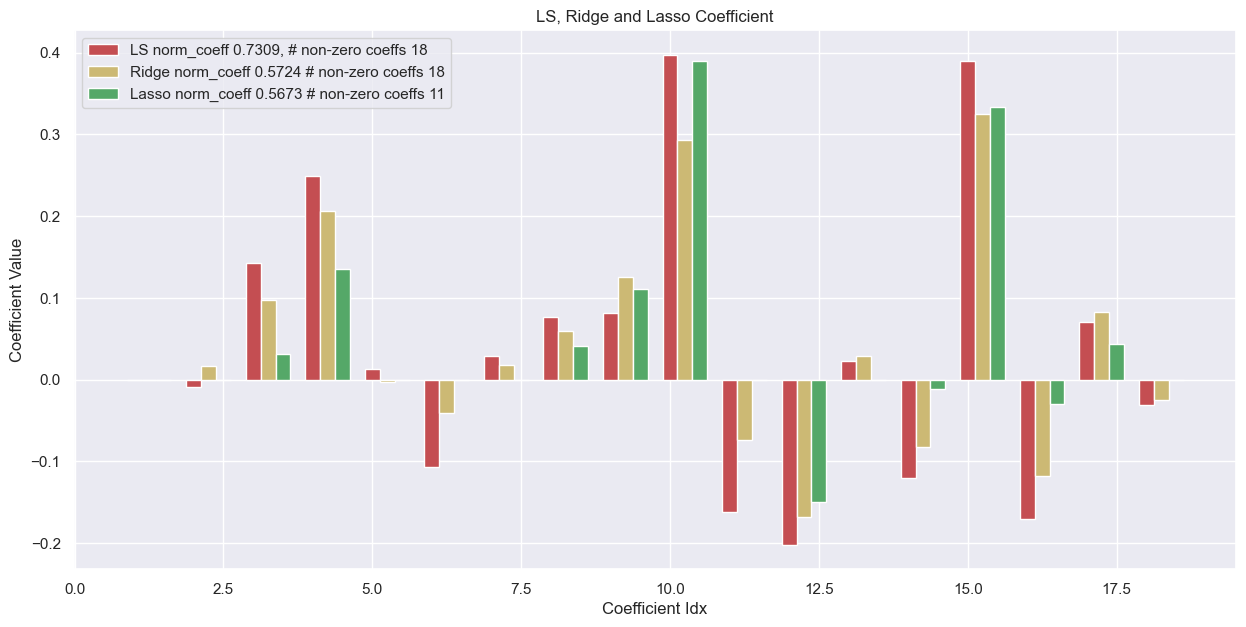

In [47]:
# Let's compare the final coefficients
ind = np.arange(1, len(w_hat_lasso_opt) + 1)  # the x locations for the groups
width = 0.25       # the width of the bars
fig, ax = plt.subplots(figsize=(15,7))
rects1 = ax.bar(ind,             w_LS_full,        width, color='r', 
                label=f'LS norm_coeff {np.linalg.norm(w_LS_full):.4}, # non-zero coeffs {sum(w_LS_full != 0)}')
rects2 = ax.bar(ind + width,     w_hat_ridge_opt, width, color='y',
               label=f'Ridge norm_coeff {np.linalg.norm(w_hat_ridge_opt):.4} # non-zero coeffs {sum(w_hat_ridge_opt != 0)}')
rects3 = ax.bar(ind + 2 * width, w_hat_lasso_opt, width, color='g',
               label=f'Lasso norm_coeff {np.linalg.norm(w_hat_lasso_opt):.4} # non-zero coeffs {sum(w_hat_lasso_opt != 0)}')
plt.xlabel('Coefficient Idx')
plt.ylabel('Coefficient Value')
plt.title('LS, Ridge and Lasso Coefficient')
plt.legend()

### TODO 13

Compare and comment the results obtained so far: did you get what you would have expected from the theory?
Type your answer in the next cell (no code needed)

YOUR ANSWER HERE

### How do LS, Ridge and LASSO reject redundant/useless features?
In the next TODOs we are going to create two new hand-crafted datasets: 
- first we simply replicate the same features a certain number of times (so that we will have redundant features)
- second we simply replicate same features and we add some noise over them

Let's see how the models we studied so far behaves in presence of this kind of nuisances.

In [48]:
# Let's first create a function to train and print in one shot all the quantities we are interested on: Training COD,
# Test COD, model parameters.

def solve_Ls_Ridge_Lasso(x_train : np.ndarray, y_train : np.array, x_test : np.ndarray, y_test : np.array):
    # Solve Ordinary LS
    COD_train_LS_full, COD_test_LS_full, w_LS_full = solve_LS_problem(x_train, y_train, x_test, y_test)
    num_folds, n_alphas, num_lambdas = 5, 100, 100
    loss = lambda y_val, x_val, model: np.linalg.norm(y_val - model.predict(x_val))**2
    
    # Solve Ridge 
    alphas = np.logspace(-3,2.5, num = n_alphas)
    loss_ridge_kfold = CV_by_hand(num_folds, linear_model.Ridge, {}, loss, alphas, x_train, y_train)
    best_index_ridge = np.argmin(loss_ridge_kfold)
    ridge_alpha_opt = alphas[best_index_ridge]
    COD_train_ridge_opt, COD_test_ridge_opt, w_hat_ridge_opt = solve_ridge_LS_problem(x_train, y_train, x_test, y_test, 
                                                                                      ridge_alpha_opt)
    
    # Solve LASSO
    lambdas = np.logspace(-4,0, num = num_lambdas)
    loss_lasso_kfold = CV_by_hand(num_folds, linear_model.Lasso, {}, loss, lambdas, x_train, y_train)
    best_index = np.argmin(loss_lasso_kfold)
    lasso_lambda_opt = lambdas[best_index]
    COD_train_lasso_opt, COD_test_lasso_opt, w_hat_lasso_opt = solve_lasso_LS_problem(x_train, y_train, x_test, y_test, 
                                                                                      lasso_lambda_opt)
    
    # The following is simply a copy and paste of what we have done earlier
    columns = ['COD_Train', 'COD_Test','w_opt']
    dict_results = {
                    'LS_full': [COD_train_LS_full, COD_test_LS_full,w_LS_full],
                    'ridge_opt': [COD_train_ridge_opt, COD_test_ridge_opt,w_hat_ridge_opt],
                    'lasso_opt': [COD_train_lasso_opt, COD_test_lasso_opt,w_hat_lasso_opt]
                   }
    results = pd.DataFrame.from_dict(dict_results, orient='index', columns=columns)
    results['Gen_gap'] = np.abs(results['COD_Train'] - results['COD_Test'])

    # Let's compare the final coefficients
    ind = np.arange(1, len(w_hat_lasso_opt) + 1)  # the x locations for the groups
    width = 0.25       # the width of the bars
    fig, ax = plt.subplots(figsize=(15,7))
    rects1 = ax.bar(ind,             w_LS_full,        width, color='r', 
                    label=f'LS norm_coeff {np.linalg.norm(w_LS_full):.4}, # non-zero coeffs {sum(w_LS_full != 0)}')
    rects2 = ax.bar(ind + width,     w_hat_ridge_opt , width, color='y',
                   label=f'Ridge norm_coeff {np.linalg.norm(w_hat_ridge_opt):.4} # non-zero coeffs {sum(w_hat_ridge_opt != 0)}')
    rects3 = ax.bar(ind + 2 * width, w_hat_lasso_opt , width, color='g',
                   label=f'Lasso norm_coeff {np.linalg.norm(w_hat_lasso_opt):.4} # non-zero coeffs {sum(w_hat_lasso_opt != 0)}')
    plt.xlabel('Coefficient Idx')
    plt.ylabel('Coefficient Value')
    plt.title('LS, Ridge and Lasso Coefficient')
    plt.legend()
    
    return results, fig, ridge_alpha_opt

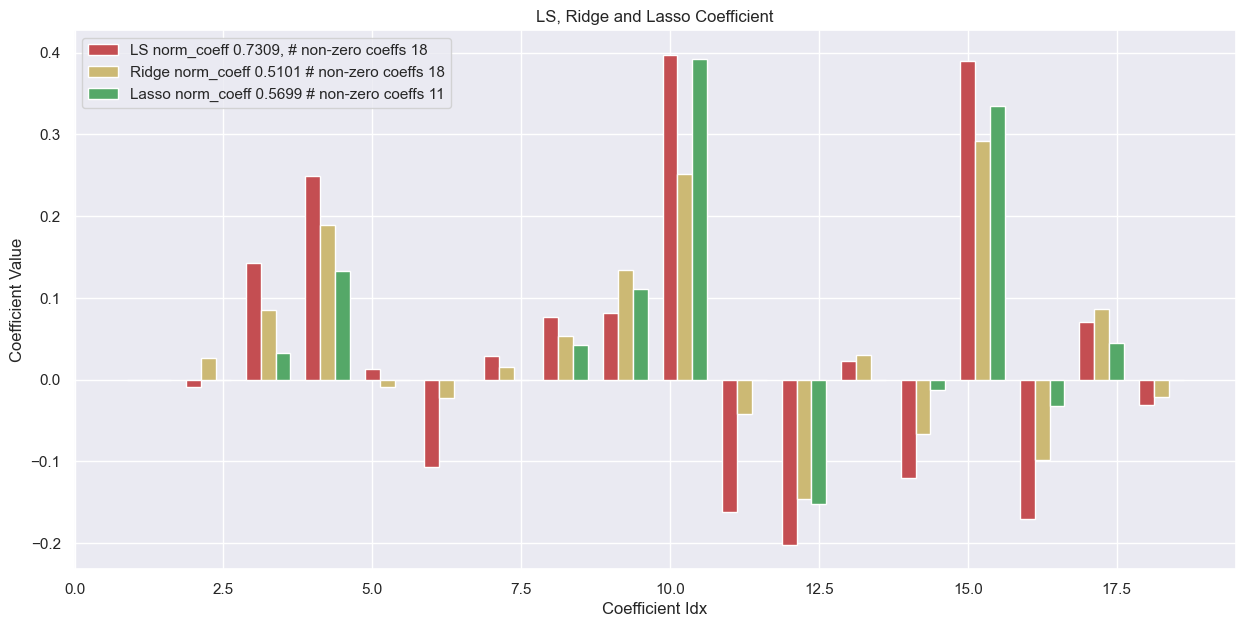

In [49]:
old_results, old_fig, _ = solve_Ls_Ridge_Lasso(x_train, y_train, x_test, y_test)

In [50]:
# We should now see the very same results we obtained earlier
old_results

,COD_Train,COD_Test,w_opt,Gen_gap
LS_full,0.638199,0.606554,"[2.7944872415333538e-15, -0.009243206869138992...",0.031644
ridge_opt,0.610659,0.621428,"[3.6740617354899245e-15, 0.026869848336010086,...",0.010769
lasso_opt,0.604416,0.592418,"[8.480926599706275e-15, 0.0, 0.032088313176038...",0.011998


In [51]:
# TODO 14
# Write a function that replicates a selected feature from a dataset x and places at the end of the new_x
def replicate_a_random_feature(x_train : np.array, x_test : np.array, chosen_feature: int) -> np.array: 
    '''
    This function replicates a chosen feature from the ones of a given dataset and return a dataset 
    containing all the old features + the copied one (In the last position!) - this operation must be
    done for the test dataset too.
    :param x_train: Features we are willing to replicate of shape (m_t, n_feats)
    :param x_test: Features we are willing to replicate of shape (m_test, n_feats)
    :chosen_feature: Index of the feature to be replicated
    
    :returns: (new_x_train, new_x_test) 
        WHERE 
            new_x_train: New set of train features with a replicated feature
                         (its shape is (m_t, n_feats + 1))
            new_x_test: New set of test features with a replicated feature 
                         (its shape is (m_test, n_feats + 1))
    '''
    # YOUR CODE HERE
    new_x_train = np.column_stack((x_train, x_train[: , chosen_feature]))
    new_x_test = np.column_stack((x_test, x_test[: , chosen_feature]))

    return (new_x_train, new_x_test) 

# Write a function that replicates a selected feature and adds a gaussian noise over it (with zero mean and variance 0.5)
def add_random_feature(x_train : np.array, x_test : np.array, chosen_feature: int) -> np.array: 
    '''
    This function replicates a chosen feature from a given dataset, adds a gaussian noise to it (with zero mean and variance 0.5) 
    and places such copy at the end of the dataset (this operation must be done for the test dataset too). 
    The noise applied on the train and test replicated features are extracted from the same gaussian distribution 
    but they are not the same realization.
    :param x_train: Features from the train dataset (m_t, n_feats)
    :param x_test: Features from the test dataset (m_test, n_feats)
    :chosen_feature: Index of the feature to be replicated
    
    :returns: (new_x_train, new_x_test) 
        WHERE 
            new_x_train: New set of train features
                         (its shape is (m_t, n_feats + 1))
            new_x_test: New set of test features
                         (its shape is (m_test, n_feats + 1))
    '''
    # YOUR CODE HERE
    variance = 0.5

    chosen_feature_train = x_train[: , chosen_feature] +  np.random.normal(loc=0, scale=np.sqrt(variance), size=x_train.shape[0])
    chosen_feature_test = x_test[: , chosen_feature] + np.random.normal(loc=0, scale=np.sqrt(variance), size=x_test.shape[0])


    new_x_train = np.column_stack((x_train, chosen_feature_train))
    new_x_test = np.column_stack((x_test, chosen_feature_test))

    return (new_x_train, new_x_test) 

In [52]:
replicated_x_train, replicated_x_test = replicate_a_random_feature(x_train, x_test,8)
added_x_train, added_x_test = add_random_feature(x_train, x_test,8)

assert (x_train.shape[0], x_train.shape[1] + 1) ==  replicated_x_train.shape
assert (x_test.shape[0], x_test.shape[1] + 1) ==  replicated_x_test.shape

assert (x_train.shape[0], x_train.shape[1] + 1) ==  added_x_train.shape
assert (x_test.shape[0], x_test.shape[1] + 1) ==  added_x_test.shape

assert np.isclose((added_x_train[:,-1]-x_train[:,8]).mean(), 0., atol=4e-1)
assert np.isclose((added_x_train[:,-1]-x_train[:,8]).var(), 0.5, atol=0.5)

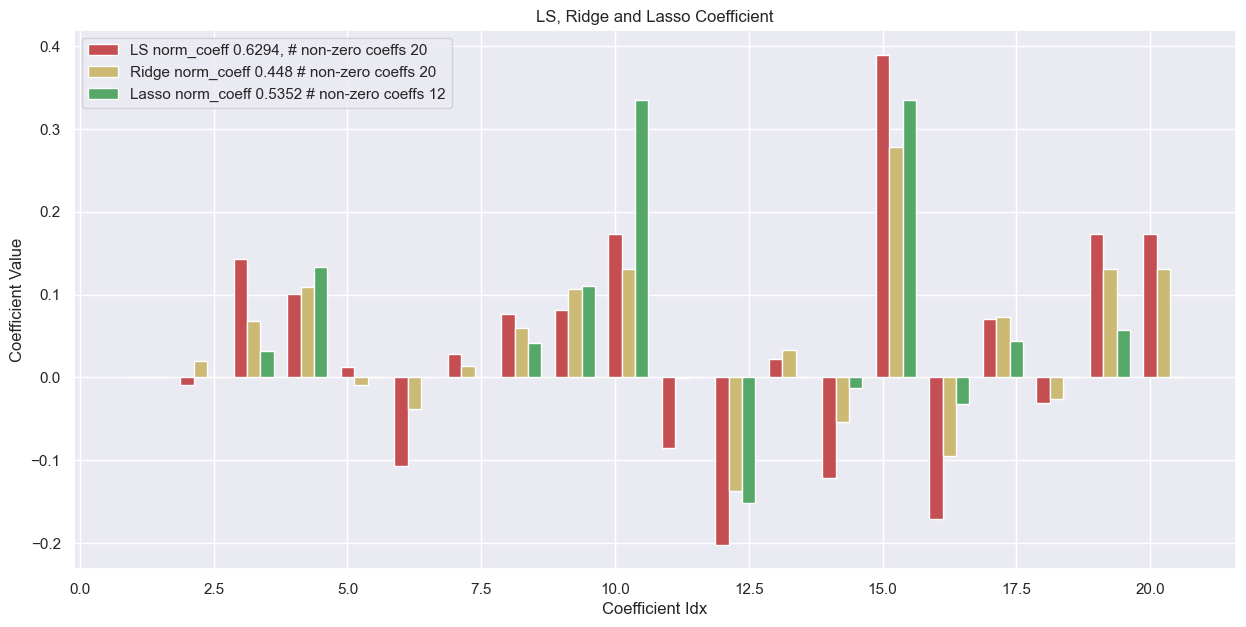

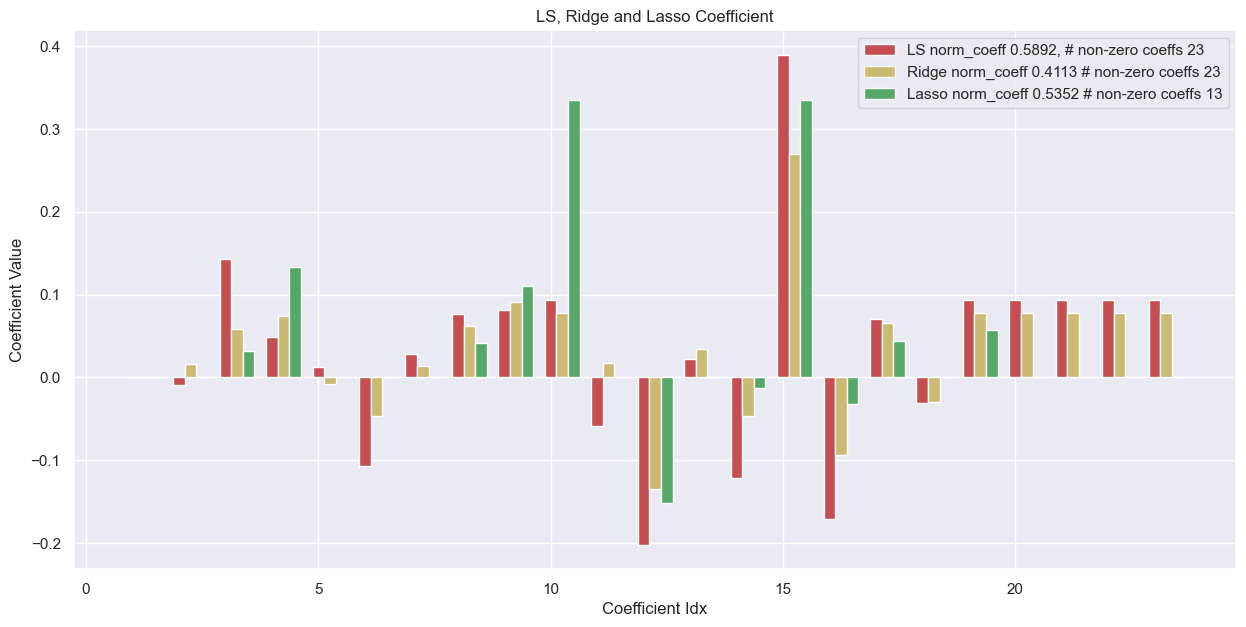

In [53]:
replicated_x_train, replicated_x_test = replicate_a_random_feature(x_train, x_test,8)
num_duplicated_features, checkpoints = 6, [2,5]
results_at_checkpoints, figs_at_checkpoints = [], []
for i in range(1, num_duplicated_features):
    if i in checkpoints:
        results, fig, _ = solve_Ls_Ridge_Lasso(replicated_x_train, y_train, replicated_x_test, y_test)
        results_at_checkpoints.append(results)
        figs_at_checkpoints.append(fig)
    replicated_x_train, replicated_x_test = replicate_a_random_feature(replicated_x_train, replicated_x_test,8) 

In [54]:
for checkpoint, results in zip(checkpoints, results_at_checkpoints):
    print(checkpoint, results)

2            COD_Train  COD_Test  \
LS_full     0.638199  0.606554   
ridge_opt   0.612501  0.611020   
lasso_opt   0.604411  0.592434   

                                                       w_opt   Gen_gap  
LS_full    [2.7849093819549447e-15, -0.009243206869138784...  0.031644  
ridge_opt  [3.906658367704023e-15, 0.020447706223987564, ...  0.001481  
lasso_opt  [8.480787261125587e-15, 0.0, 0.032108351728761...  0.011977  
5            COD_Train  COD_Test  \
LS_full     0.638199  0.606554   
ridge_opt   0.612207  0.603884   
lasso_opt   0.604411  0.592434   

                                                       w_opt   Gen_gap  
LS_full    [2.7815073026177018e-15, -0.009243206869139164...  0.031644  
ridge_opt  [4.018264096644556e-15, 0.016447003877337718, ...  0.008324  
lasso_opt  [8.480787261125587e-15, 0.0, 0.032108351728761...  0.011977  


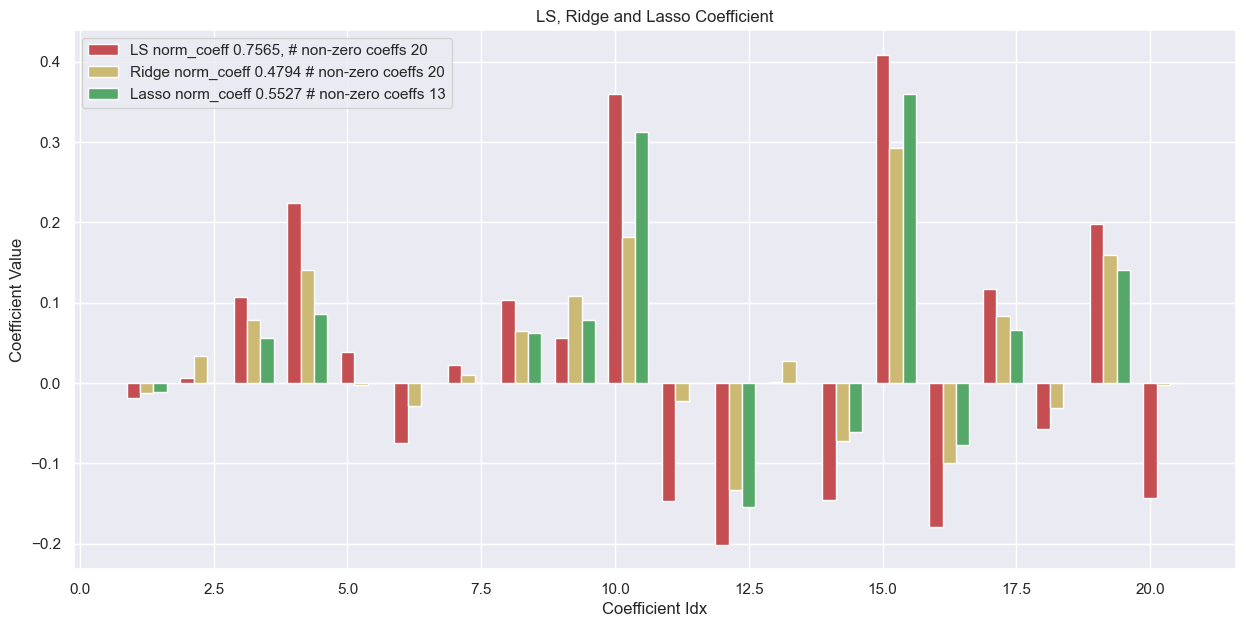

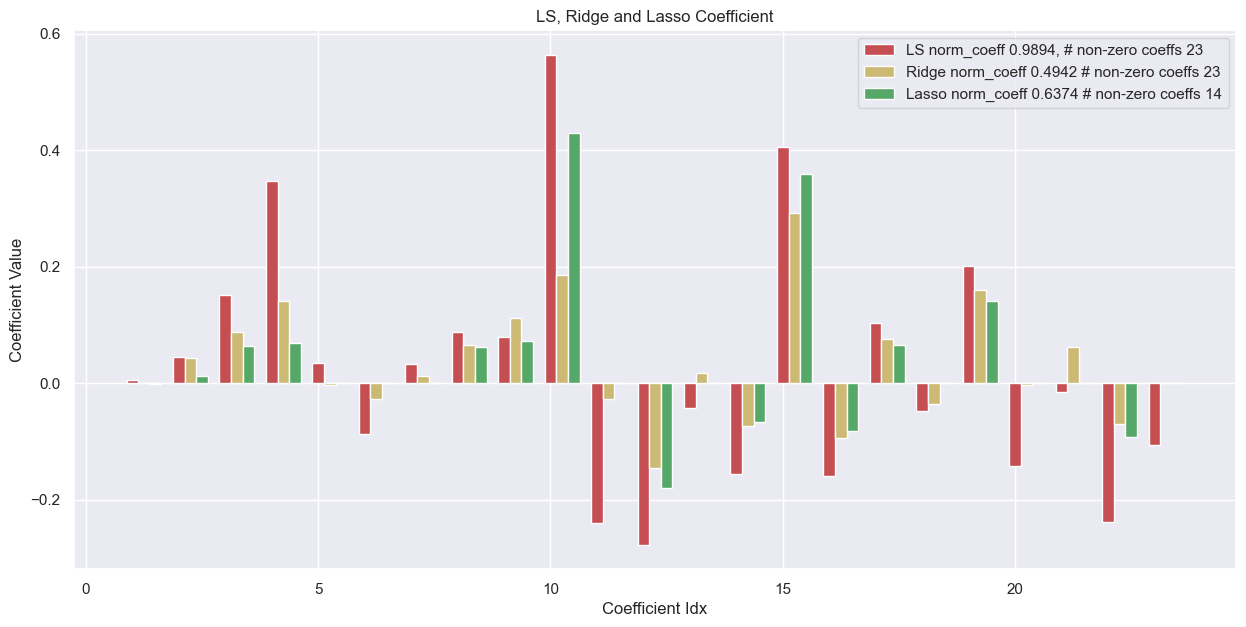

In [55]:
added_x_train, added_x_test = add_random_feature(x_train, x_test,8)
num_added_features, checkpoints = 6, [2,5]
added_results_at_checkpoints, added_figs_at_checkpoints = [], []
for i in range(1, num_added_features):
    if i in checkpoints:
        results, fig, bbb = solve_Ls_Ridge_Lasso(added_x_train, y_train, added_x_test, y_test)
        added_results_at_checkpoints.append(results)
        added_figs_at_checkpoints.append(fig)
    added_x_train, added_x_test = add_random_feature(added_x_train, added_x_test,8) 

In [56]:
for checkpoint, results in zip(checkpoints, added_results_at_checkpoints):
    print(checkpoint, results)

2            COD_Train  COD_Test  \
LS_full     0.657394  0.571669   
ridge_opt   0.621948  0.599778   
lasso_opt   0.626567  0.586137   

                                                       w_opt   Gen_gap  
LS_full    [-0.018279720695196688, 0.006572880865222793, ...  0.085725  
ridge_opt  [-0.012735120371948109, 0.03334669958454753, 0...  0.022170  
lasso_opt  [-0.011188020287886544, 0.0005426264214424312,...  0.040430  
5            COD_Train  COD_Test  \
LS_full     0.693673  0.541830   
ridge_opt   0.633530  0.595118   
lasso_opt   0.647847  0.582222   

                                                       w_opt   Gen_gap  
LS_full    [0.004753187089002686, 0.04494808144541845, 0....  0.151843  
ridge_opt  [-0.00039540664296089606, 0.04406538829866223,...  0.038411  
lasso_opt  [-0.0005343959642387263, 0.012160122340171239,...  0.065625  


### TODO 15 

Comment in the next cell the results obtained using LS, Ridge and LASSO after we added redundant/useless features.

YOUR ANSWER HERE